In [541]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [542]:
train = pd.read_csv('../ventilator-pressure-prediction-data/train.csv')

In [543]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


Informationen über die Datentypen

In [544]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6036000 entries, 0 to 6035999
Data columns (total 8 columns):
 #   Column     Dtype  
---  ------     -----  
 0   id         int64  
 1   breath_id  int64  
 2   R          int64  
 3   C          int64  
 4   time_step  float64
 5   u_in       float64
 6   u_out      int64  
 7   pressure   float64
dtypes: float64(3), int64(5)
memory usage: 368.4 MB


In [545]:
train.isnull().any()

id           False
breath_id    False
R            False
C            False
time_step    False
u_in         False
u_out        False
pressure     False
dtype: bool

Hier sind Mittelwert und Standardabeichung wie in der Vorstellung der Daten zu sehen.

In [546]:
train.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


In [547]:
train['id'].duplicated().any()

False

**Individuelle Atemzüge**

Anzahl individueller Atemnzüge

In [548]:
unique_breaths = train['breath_id'].unique()
number_breaths = len(unique_breaths)
print(number_breaths)

75450


Mehrere Datenpunkte pro Atemzug

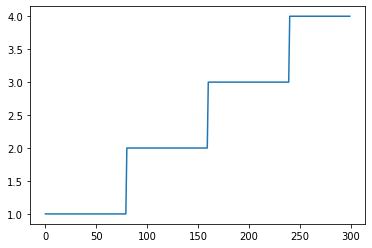

In [549]:
train['breath_id'][:300].plot();

Jeder Atemzug hat exakt 80 Datenpunkte

In [550]:
breath_lengths = train[['id','breath_id']].groupby('breath_id').count()['id']
breath_lengths.unique()

array([80])

Da alle Atemnzüge die selbe Länge haben, können wir diese als Konstate erstellen.

In [551]:
BREATH_LENGTH = breath_lengths.unique()[0]

**R und C, Lungeneigenschaften**

R und C sind inenrhalb eines Atemzuges kostant

In [552]:
r_c_std_in_breaths = train[['breath_id','R','C']].groupby('breath_id').std()
print(r_c_std_in_breaths['R'].unique())
print(r_c_std_in_breaths['C'].unique())

[0.]
[0.]


R hat 3 paarweise verschiedene Werte. Diese sind 5, 20 und 50, wie in der Datenvorstellung schon gesehen.

In [553]:
r_values = train[['breath_id', 'R']].groupby('breath_id').mean()['R']
print('Unique values:')
print(r_values.value_counts())

r_unique = np.sort(r_values.unique()).astype(int)

Unique values:
50    30126
5     24860
20    20464
Name: R, dtype: int64


C hat ebenfalls 3 paarweise verschiedene Werte. Diese sind 10, 20 und 50, wie in der Datenvorstellung schon gesehen. 

In [554]:
c_values = train[['breath_id', 'C']].groupby('breath_id').mean()['C']
print('Unique values:')
print(c_values.value_counts())

c_unique = np.sort(c_values.unique()).astype(int)

Unique values:
10    28059
50    24646
20    22745
Name: C, dtype: int64


Wie hängen nun die verschiedenen R und C Werte zusammen? 

Für R = 5 sind die drei C Werte gleichverteilt. 
Für R = 20 kommt C = 50 am häufigsten vor,
Für R = 50 ist C = 10 am häufigsten.

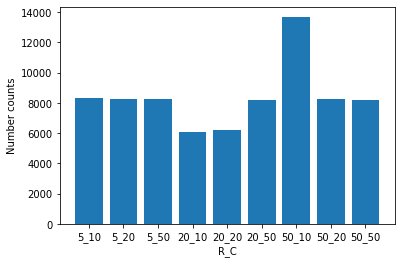

In [555]:
rc_values = np.array([
    [r, c, len(train[(train['R'] == r) & (train['C'] == c)])//BREATH_LENGTH] 
    for r in r_unique 
    for c in c_unique
])

x = range(len(rc_values))
plt.bar(x, rc_values[:,2])
plt.xticks(x, [str(r) + '_' + str(c) for r, c in rc_values[:,:2] ])
plt.xlabel('R_C')
plt.ylabel('Number counts')
plt.show()

Für C = 10 kommt R = 50 am häufigsten vor, 
Für C = 20 teilen sich R = 5 und R = 50 die meisten Counts, 
Für C = 50 sind die drei R Werte gleich verteilt.

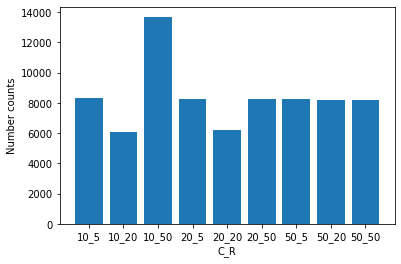

In [556]:
cr_values = np.array([
    [c, r, len(train[(train['C'] == c) & (train['R'] == r)])//BREATH_LENGTH] 
    for c in c_unique 
    for r in r_unique
])

x = range(len(cr_values))
plt.bar(x, cr_values[:,2])
plt.xticks(x, [str(c) + '_' + str(r) for c, r in cr_values[:,:2] ])
plt.xlabel('C_R')
plt.ylabel('Number counts')
plt.show()

**Individuelle Atemzüge**

Wie viele individuelle Atmenzüge gibt es??

In [557]:
unique_breaths = train['breath_id'].unique()
num_breaths = len(unique_breaths)
print(num_breaths)

75450


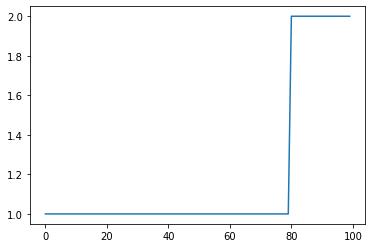

In [558]:
train['breath_id'][:100].plot();

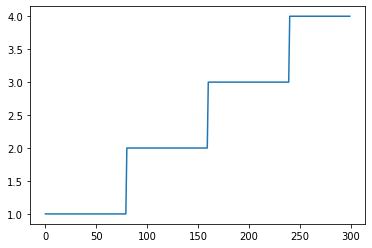

In [559]:
train['breath_id'][:300].plot();

Es sieht aus als wären alle Atmenzüge genau 80 Datenpunkte groß. 

In [560]:
breath_lengths = train[['id','breath_id']].groupby('breath_id').count()['id']
breath_lengths.unique()

array([80])

Ja, es gilt: Alle Atemzüge sind genau 80 Datenpunkte groß.

In [561]:
r_c_std_in_breaths = train[['breath_id','R','C']].groupby('breath_id').std()
print(r_c_std_in_breaths['R'].unique())
print(r_c_std_in_breaths['C'].unique())

[0.]
[0.]


Keine Standartabweichung innerhalb R und C. Daraus folgt: inenrhalb eines Atemzuges sind R und C konstant!|

**Time steps in individuellen Atmenzügen**

Wie sind die ersten beiden Atemzüge (als Beispiel) auf ihre Zeitschritte aufgeteilt?

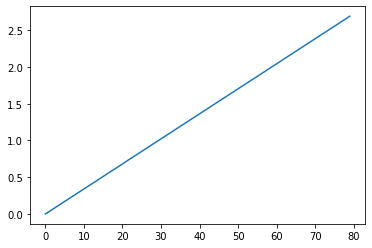

In [562]:
first_breath  = train[train['breath_id'] == 1]
second_breath = train[train['breath_id'] == 2]

x = range(BREATH_LENGTH)
t1 = first_breath['time_step']
t2 = second_breath['time_step']
plt.plot(x, t1)

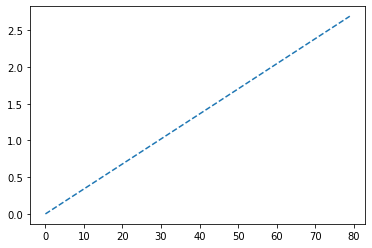

In [563]:
plt.plot(x, t2, ls = '--')

Sieht recht gleichmäßig aus. Trügt das?

Text(0, 0.5, 'Zeitdifferenz')

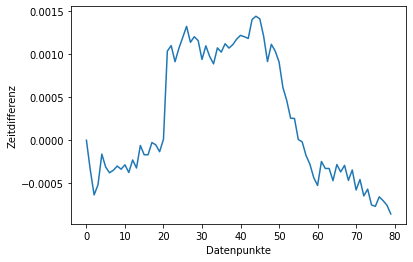

In [564]:
plt.plot(t1.values - t2.values);
plt.xlabel('Datenpunkte')
plt.ylabel('Zeitdifferenz')


Die ersten beien Atemzüge haben Unterschiede in ihrem zeitlichem Verlauf.

Keine Standartabweichung beim Startwert des Zeitschrittes: Alle Atemzüge starten bei 0.

In [565]:
train[['breath_id', 'time_step']].groupby('breath_id').min()['time_step'].std()

0.0

Wie lange ist ein Atemzug?

In [566]:
time_step_max = train[['breath_id', 'time_step']].groupby('breath_id').max()['time_step']
time_step_max.describe()

count    75450.000000
mean         2.614803
std          0.087102
min          2.496809
25%          2.523674
50%          2.655257
75%          2.689902
max          2.937238
Name: time_step, dtype: float64

Alle Atemzüge sind zwischen 2,5 und 2,9 Sekunden lang. 

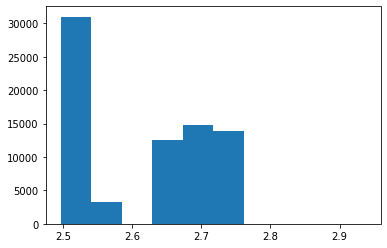

In [567]:
plt.hist(time_step_max);

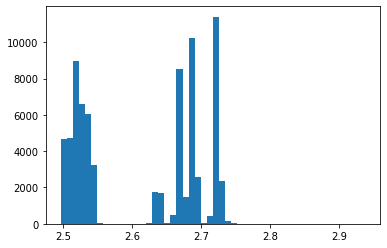

In [568]:
plt.hist(time_step_max, 50);

Alle Atemzüge haben 80 Datenpunkte, aber nicht die selbe Länge. Daraus folgt: nicht alle Zeitschritte sind gleich lang.

**Zeitschritt-Längen**

Wie sind nun die Zeitschrittlängen auf die einzelnen Atemzüge aufgeteitl?

In [569]:
train['dt'] = train['time_step'].diff()
time_step_size = train[train.dt >= 0]
train['dt'] = time_step_size.dt
time_step_size.dt.describe()

count    5.960550e+06
mean     3.309877e-02
std      1.232990e-03
min      3.144002e-02
25%      3.189349e-02
50%      3.345442e-02
75%      3.404546e-02
max      2.510931e-01
Name: dt, dtype: float64

Negative Werte: entstehen bei einem Übergang von einem Atemzug zum anderen und sollen nicht betrachtet werden. 
Warum der eine Ausreiser bei max? -> ist tatächlich einfach ein großer Sprung.

In [570]:
train[train.dt == train.dt.max()]

,id,breath_id,R,C,time_step,u_in,u_out,pressure,dt
2128959,2128960,44245,50,10,2.937238,4.996405,1,6.189002,0.251093


In [571]:
max_id = train[train.dt == train.dt.max()].id.max()
whats_up = train[(train.id <= (max_id + 5)) & (train.id > (max_id - 5))]
whats_up

,id,breath_id,R,C,time_step,u_in,u_out,pressure,dt
2128955,2128956,44245,50,10,2.591004,4.979698,1,6.329607,0.031732
2128956,2128957,44245,50,10,2.622747,4.982678,1,6.470211,0.031743
2128957,2128958,44245,50,10,2.654503,4.985221,1,6.118700,0.031755
2128958,2128959,44245,50,10,2.686145,4.987384,1,6.540513,0.031642
2128959,2128960,44245,50,10,2.937238,4.996405,1,6.189002,0.251093
2128960,2128961,44248,50,50,0.000000,28.258151,0,6.118700,NaN
2128961,2128962,44248,50,50,0.031781,27.465058,0,9.071390,0.031781
2128962,2128963,44248,50,50,0.063486,27.178008,0,11.321059,0.031704
2128963,2128964,44248,50,50,0.095173,26.335851,0,20.179129,0.031688
2128964,2128965,44248,50,50,0.127887,25.066763,0,27.420250,0.032713


Gibt es viele Ausreiser neben dem offensichtlichen Peak? Minimum bis 75%-Quantil haben alle ungefähr die selbe Größenordnung. Wieviele Punkte liegen jetzt also ganz außerhalb? 

Bis 0,05 sind es nur eine Handvoll Werte, diese können weggelassen werden? Gehen vielleicht noch mehr?

In [572]:
len(train[train['dt'] > 0.05])

30

In [573]:
len(train[train['dt'] > 0.0355])

5438

(array([181995., 166064., 146773., 119601., 109638., 101371.,  95779.,
         84728.,  79611.,  75781.,  67464.,  50582.,  32272.,  19995.,
         12730.,   8395.,   5604.,   3712.,   2568.,   2085.,   1893.,
          1807.,   2187.,   2846.,   3829.,   5394.,   7660.,  10127.,
         13587.,  15953.,  18765.,  20982.,  23525.,  28244.,  30174.,
         32922.,  31189.,  28117.,  24195.,  20090.,  16785.,  13839.,
         11207.,   8456.,   6135.,   3995.,   2481.,   1588.,    885.,
           608.]),
 array([0.03400016, 0.03403015, 0.03406014, 0.03409014, 0.03412013,
        0.03415012, 0.03418012, 0.03421011, 0.0342401 , 0.0342701 ,
        0.03430009, 0.03433008, 0.03436007, 0.03439007, 0.03442006,
        0.03445005, 0.03448005, 0.03451004, 0.03454003, 0.03457003,
        0.03460002, 0.03463001, 0.03466001, 0.03469   , 0.03471999,
        0.03474998, 0.03477998, 0.03480997, 0.03483996, 0.03486996,
        0.03489995, 0.03492994, 0.03495994, 0.03498993, 0.03501992,
        

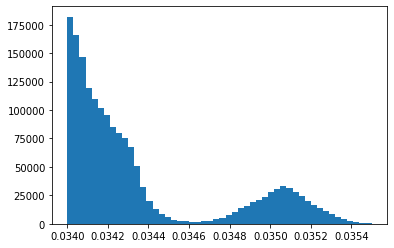

In [574]:
points_between_75_and_100 = train[(train['dt'] > 0.034) & (train['dt'] < 0.0355)].dt
plt.hist(points_between_75_and_100, 50) #np.arange(0.0, 1.0, 0.2))

So werden unter 0,1% alles Punkte als Outlier weggelassen. Das ist vermutlich ok? Mal sehen was noch so passiert. 

(array([1311783., 1054878.,   78776.,  257882.,  296109.,  662230.,
        1652829.,  256879.,  228584.,  155162.]),
 array([0.03144002, 0.031846  , 0.03225198, 0.03265796, 0.03306394,
        0.03346992, 0.03387589, 0.03428187, 0.03468785, 0.03509383,
        0.03549981]),
 <BarContainer object of 10 artists>)

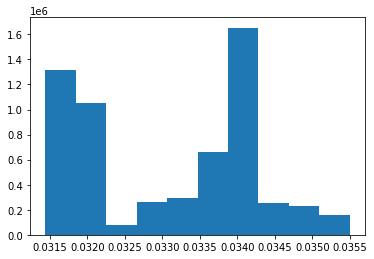

In [575]:
dt = train[(train['dt'] > 0.031) & (train['dt'] < 0.0355)].dt
plt.hist(dt)

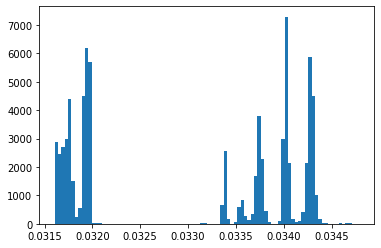

In [576]:

# reshape: soritert Array um, in diesem Fall ganz explizit die Einträge aus dt
# (-1,breath_lengths) meint: egal wie viele es werden (-1), die einzelnen Array Einträge müssen nur breath_length Länge haben.
# median: berechnet den median entlang einer Achse, axis = -1: median über eine breath_length hinweg. (Für alle Atemzüge, gibt ein Array zurück)
# ~train.dt.isna(): Entfernt alle Nan-Werte (entstehen weil vorher negative Werte weggenommen wurden)
dt_median = np.median(np.reshape(train['dt'][~train.dt.isna()].values, (-1, (BREATH_LENGTH - 1))), axis = -1)
plt.hist(dt_median, 90);

Wie hoch ist die Standartabweichung der einzelnen Atemzüge bezüglich der Zeitschrittlängen?

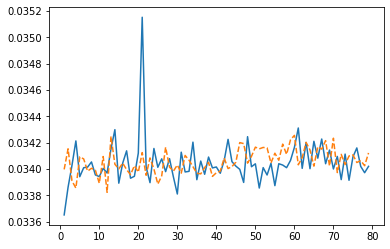

In [577]:
# Na-Werte werden nicht geplottet
first_breath  = train[train['breath_id'] == 1]
second_breath = train[train['breath_id'] == 2]

x = range(BREATH_LENGTH)
dt1 = first_breath['dt']
dt2 = second_breath['dt']
plt.plot(x, dt1)
plt.plot(x, dt2, ls = '--')

Die meisten Atemzüge haben eine kleine Standartabweichung: Wenn sie in einem der Peaks von oben beginnen, enden sie auch in diesem.

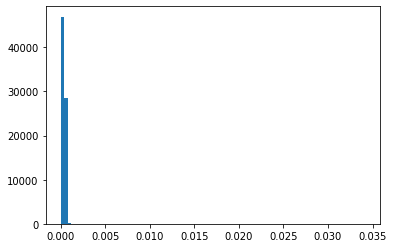

In [578]:
dt_std = np.std(np.reshape(train['dt'][~train.dt.isna()].values, (-1, (BREATH_LENGTH - 1))), axis = -1)
plt.hist(dt_std, 90);

**u_out Ventilator Attribut**

Zwei Beispiel Atemzüge. u_out verändert seinen Wert innerhalb eines Atemzuges.

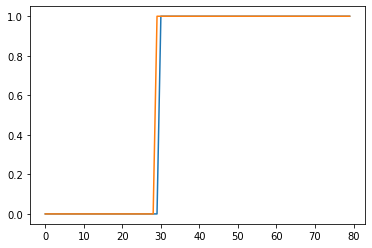

In [579]:
first_u_out  = first_breath['u_out']
second_u_out = second_breath['u_out']
plt.plot(range(BREATH_LENGTH), first_u_out)
plt.plot(range(BREATH_LENGTH), second_u_out)

Wo innerhalb eines Atemzuges schaltet u_out um?

(array([1.0000e+01, 3.0000e+00, 0.0000e+00, 0.0000e+00, 1.2300e+02,
        2.2803e+04, 0.0000e+00, 1.8260e+04, 1.7923e+04, 1.6328e+04]),
 array([25. , 25.7, 26.4, 27.1, 27.8, 28.5, 29.2, 29.9, 30.6, 31.3, 32. ]),
 <BarContainer object of 10 artists>)

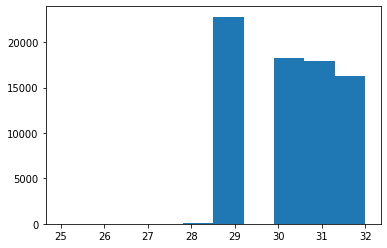

In [580]:
u_out_diff = train['u_out'].diff()
# an dieser Stelle ist der u_out Übergang
u_out_transitions = u_out_diff.index[u_out_diff == 1] % BREATH_LENGTH
plt.hist(u_out_transitions)

Wird u_out irgendwann innerhalb eines Atemzuges von 1 auf 0 geschaltet? Nein.

In [581]:
# assert gibt einen AssertionError, wenn Aussage falsch.
u_out_decreases        = train['u_out'].diff()[1:].values < 0
breath_id_remains_same = train['breath_id'].diff()[1:].values == 0
assert(np.max(u_out_decreases * breath_id_remains_same) == 0)

Wie verhält sich die Lage des Übergangs zu der Länge des Atemzuges? Könnte es sein, dass u_out immer nach der gleichen Zeit umgeschaltet wird?

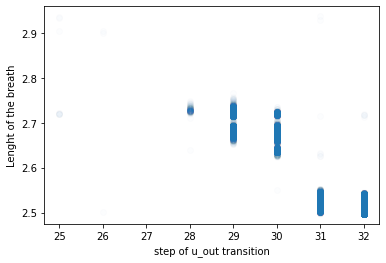

In [582]:
plt.scatter(u_out_transitions, time_step_max, alpha = 0.01);
plt.ylabel('Lenght of the breath')
plt.xlabel('step of u_out transition');

Hier sind die Zeiten der letzten u_out = 0 Werte.

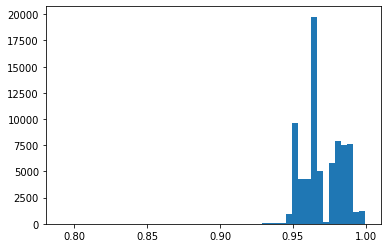

In [583]:
u_out_still_zero = u_out_diff.index[u_out_diff == 1] - 1
times_before_transition = train['time_step'][u_out_still_zero]
plt.hist(times_before_transition, 50)
# gibt Fehler, falls u_out = 1 dabei ist.
assert(max(train['u_out'][u_out_still_zero]) == 0)

Hier ist der erste u_out = 1 Wert.

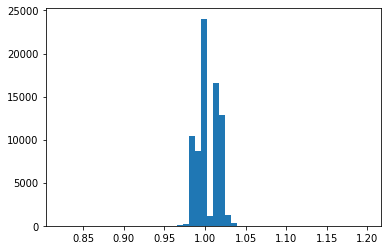

In [584]:
u_out_first_one = u_out_diff.index[u_out_diff == 1]
times_after_transition = train['time_step'][u_out_first_one]
plt.hist(times_after_transition,50)
# gibt Fehler, wenn ein u_out = 0 dabei ist.
assert(min(train['u_out'][u_out_first_one]) == 1)

Schaltet ungefähr bei 0,99 um.

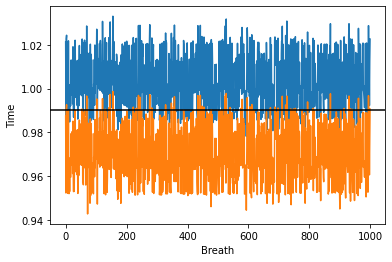

In [585]:
plt.plot(times_after_transition[:1000].values)
plt.plot(times_before_transition[:1000].values)
plt.axhline(0.99, c = 'k');
plt.ylabel('Time');
plt.xlabel('Breath');

**u_in Ventilator Attribut**

Wie spielen u_out und u_in zusammen?

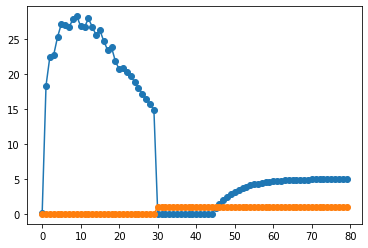

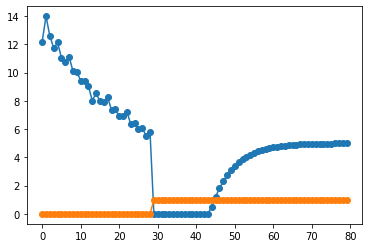

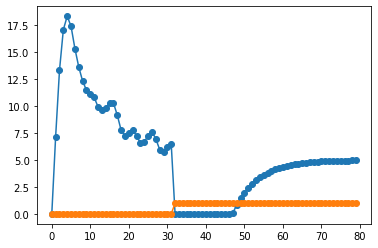

In [586]:
for idx in range(3):
    plt.plot(range(BREATH_LENGTH), train[train['breath_id'] == unique_breaths[idx]]['u_in'], marker = 'o')
    plt.plot(range(BREATH_LENGTH), train[train['breath_id'] == unique_breaths[idx]]['u_out'], marker = 'o')
    plt.show()

Hier ist noch mal der recht gleichförmige Verlauf nach dem Einschalten von u_out zu sehen. 

In [587]:
u_out_transitions

Int64Index([30, 29, 32, 32, 29, 29, 29, 29, 31, 32,
            ...
            29, 31, 30, 31, 32, 29, 30, 30, 31, 30],
           dtype='int64', length=75450)

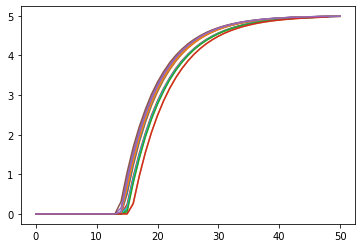

In [588]:
for idx in range(15):
    u_in = train[train['breath_id'] == unique_breaths[idx]]['u_in']
    u_out_transition = u_out_transitions[idx]
    step_since_transition = range(BREATH_LENGTH - u_out_transition)
    plt.plot(step_since_transition, u_in[u_out_transition:])

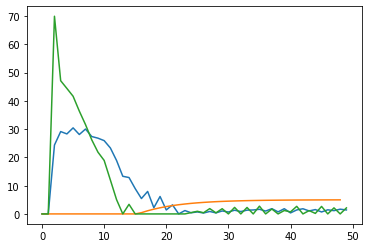

In [589]:
for idx in [15,16,29]:
    u_in = train[train['breath_id'] == unique_breaths[idx]]['u_in']
    u_out_transition = u_out_transitions[idx]
    step_since_transition = range(BREATH_LENGTH - u_out_transition)
    plt.plot(step_since_transition, u_in[u_out_transition:])

Zeit als x-Achse auch nicht besser? (Was wollte der Mensch aus dem Notebook damit sagen?)

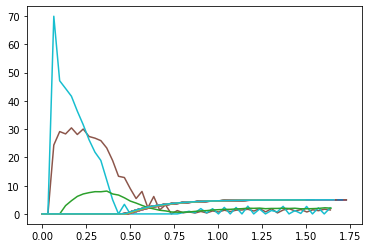

In [590]:
for idx in range(50):
    u_in = train[train['breath_id'] == unique_breaths[idx]]['u_in']
    u_out_transition = u_out_transitions[idx]
    time_steps = train[train['breath_id'] == unique_breaths[idx]]['time_step'].values
    time_since_transition = time_steps - time_steps[u_out_transition]
    plt.plot(time_since_transition[u_out_transition:], u_in[u_out_transition:])

Maxima-Verteilung der u_in Werte. (Maximum pro Atemzug)

Text(0.5, 0, 'max u_in')

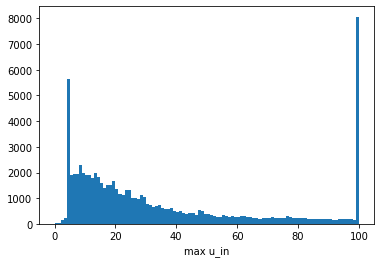

In [591]:
plt.hist(train[['breath_id', 'u_in']].groupby('breath_id').max()['u_in'], 100);
plt.xlabel('max u_in')

**Pressure**

Durchschnittlicher Atemzug. (Durchschnittlicher Druck über alle Atemzüge an jedem Datenpunkt einzeln)

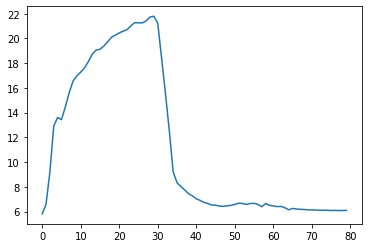

In [592]:
avgs = np.zeros(BREATH_LENGTH)
for t in range(BREATH_LENGTH):
    avgs[t] = train['pressure'][t::BREATH_LENGTH].mean()
plt.plot(avgs)

Negativer Druck

In [593]:
len(train[train['pressure'] <= 0])

3713

In [594]:
negative_pressure_breaths = train[train['pressure'] <= 0]['breath_id'].unique()
negative_pressure_breaths

array([   542,    851,   3928,   7949,  11216,  13594,  16599,  19236,
        20075,  22164,  23710,  27195,  27731,  30127,  36474,  40431,
        40753,  43103,  43630,  44309,  45099,  45681,  45877,  46018,
        46020,  46486,  47325,  49376,  49941,  50459,  52137,  53057,
        54206,  56152,  56760,  57119,  58835,  59101,  60949,  65596,
        67080,  67788,  70753,  71461,  72011,  74977,  77803,  83713,
        85391,  86508,  90584,  91132,  91464,  92955,  94037,  97520,
        98041,  98080, 101951, 106703, 108406, 109424, 109761, 110499,
       111419, 112036, 113323, 113639, 118131, 119582, 120445, 121570,
       124575])

u_in für alle nagetiven Druck-Datenpunkte

Text(0.5, 0, 'max u_in for negative pressure')

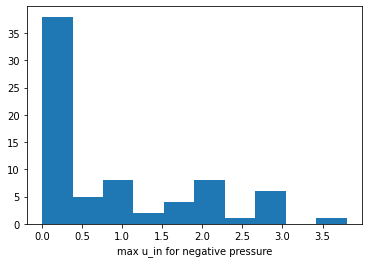

In [595]:
max_u_in_for_negative_pressure_breaths = [train[train['breath_id'] == b]['u_in'].max() for b in negative_pressure_breaths]
plt.hist(max_u_in_for_negative_pressure_breaths);
plt.xlabel('max u_in for negative pressure')

Initialer Druck (bei Datenpunkt 0) für jeden Atemzug

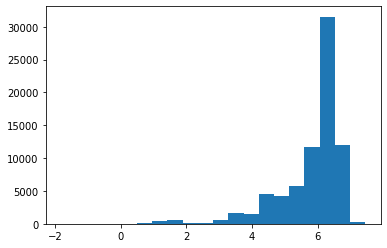

In [596]:
initial_pressure = train['pressure'][::BREATH_LENGTH]
plt.hist(initial_pressure,20);

Woher kommt der?

u_int reicht nicht aus. 

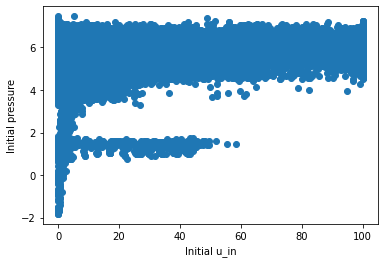

In [597]:
initial_u_in = train['u_in'][::BREATH_LENGTH]
plt.scatter(initial_u_in, initial_pressure);
plt.ylabel('Initial pressure')
plt.xlabel('Initial u_in');

R und C Werte gegen Initialen Druck geplottet.

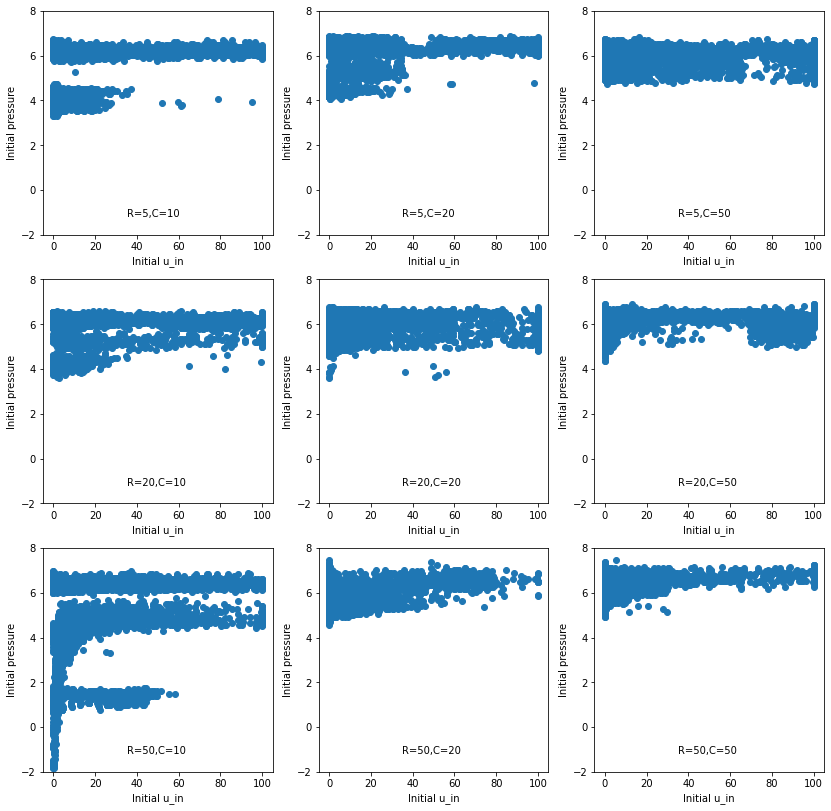

In [598]:
fig, axs = plt.subplots(len(r_unique), len(c_unique), figsize=(14,14))
for i, r in enumerate(r_unique):
    for j, c in enumerate(c_unique):
        foo = train[(train['R'] == r) & (train['C'] == c)]
        axs[i,j].scatter(foo['u_in'][::BREATH_LENGTH], foo['pressure'][::BREATH_LENGTH]);
        # macht, dass alle gleich skaliert sind
        axs[i,j].set_ylim([-2,8])
        axs[i,j].text(35,-1.2,f'R={r},C={c}')
        axs[i,j].set_ylabel('Initial pressure')
        axs[i,j].set_xlabel('Initial u_in');

noch mal ohne u_in. War wie oben schon gesagt, nicht so wichtig. 

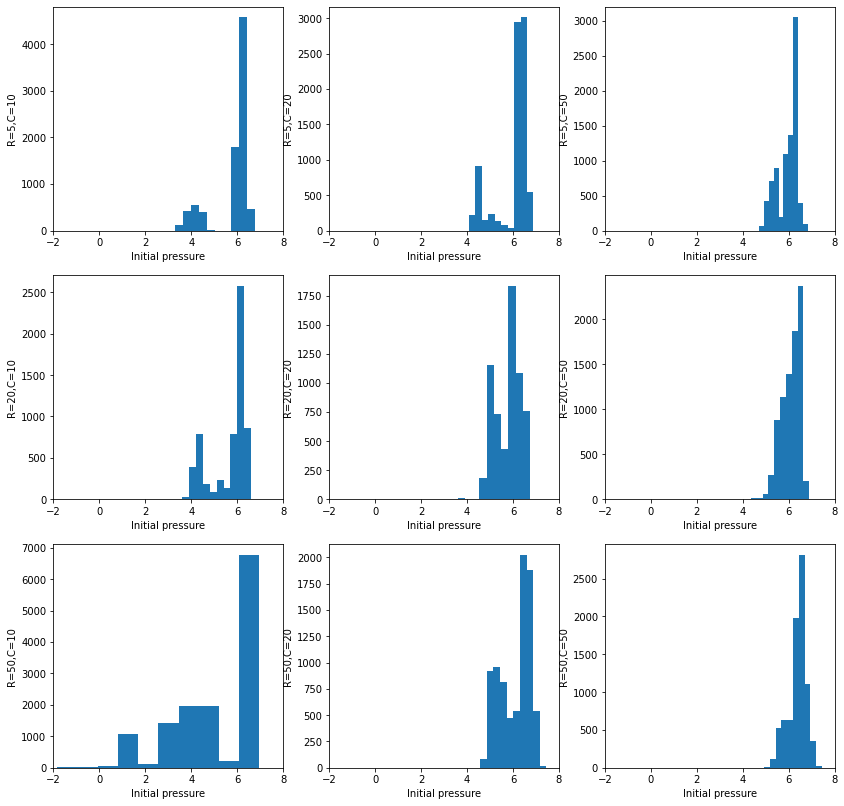

In [599]:
fig, axs = plt.subplots(len(r_unique), len(c_unique), figsize=(14,14))
for i, r in enumerate(r_unique):
    for j, c in enumerate(c_unique):
        foo = train[(train['R'] == r) & (train['C'] == c)]
        axs[i,j].hist(foo['pressure'][::BREATH_LENGTH]);
        axs[i,j].set_xlim([-2,8])
        axs[i,j].set_ylabel(f'R={r},C={c}')
        axs[i,j].set_xlabel('Initial pressure');

Viele Atemzüge über die Zeit mit verschiedenen R und C Werten.

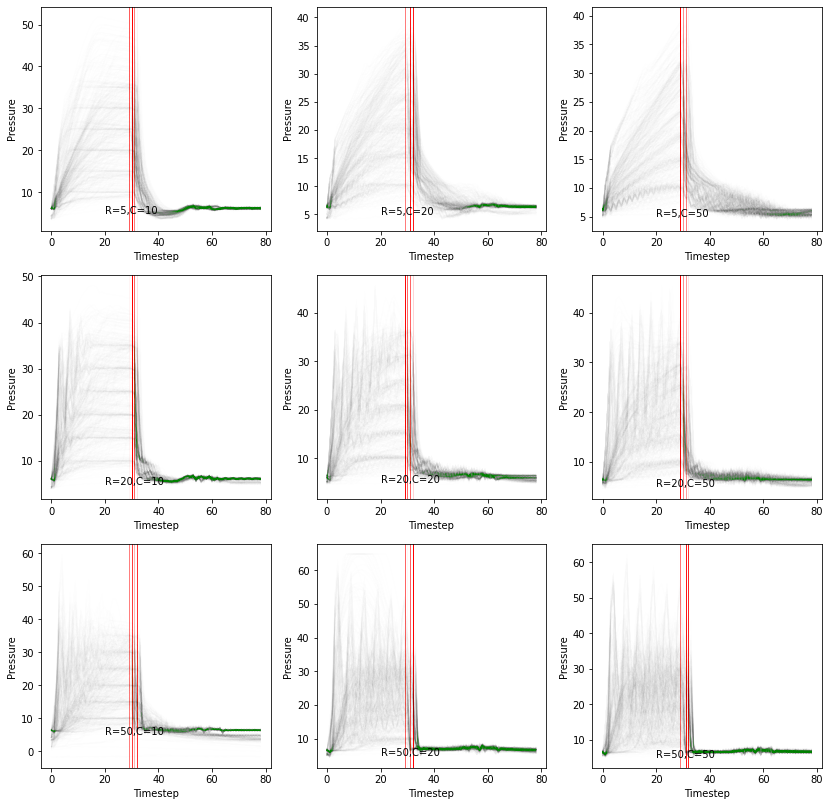

In [540]:
fig, axs = plt.subplots(len(r_unique), len(c_unique), figsize=(14,14))
for i, r in enumerate(r_unique):
    for j, c in enumerate(c_unique):
        foo = train[(train['R'] == r) & (train['C'] == c)]
        for k in range(600):
            kter_breath = foo[k*BREATH_LENGTH:k*BREATH_LENGTH+79]
            u_out_diff = kter_breath['u_out'].diff()
            u_out_first_one = (u_out_diff.index[u_out_diff == 1] % BREATH_LENGTH).max()
            axs[i,j].plot(range(79), kter_breath['pressure'], c = 'g', alpha = 0.005);
            axs[i,j].axvline(u_out_first_one, color = 'r', lw = 1, alpha = 0.005)
        axs[i,j].text(20,5,f'R={r},C={c}')
        axs[i,j].set_ylabel('Pressure')
        axs[i,j].set_xlabel('Timestep');    
